<a href="https://colab.research.google.com/github/bartoszpankratz/VAR_neural_network/blob/master/2019_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from os.path import join, isfile
from os import listdir
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

from Data import Data
from VaR import VaR


#### Turn off the warnings due to neural networks
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Declare paths
PATH_MAIN  = ""
PATH_DATA  = join(PATH_MAIN,'0_Data')
PATH_PLOT  = join(PATH_MAIN,'1_Plot')
PATH_GRAPH = join(PATH_MAIN, '2_Graph')
DICTIONARY = pd.read_excel(join(PATH_MAIN, 'Dictionary.xlsx'))

In [ ]:
VAR_PARAMS = {
            'ALPHA'       : [0.01, 0.05], 
            'LOOK_BACK'   : 250,
            'TRAIN_PERIOD': 0.5
         }

In [ ]:
# Load empirical data
data_emp = [Data(path = PATH_DATA, file = f) for f in listdir(PATH_DATA) if isfile(join(PATH_DATA, f))];
[data_emp[i].get_data(DICTIONARY) for i in range(len(data_emp))];

In [ ]:
SIM_PARAM = {'PROCESS': 'GJR_GARCH', 
         'SIM_LEN': 100000,
         'INIT': [0, 0.1],
         'P_PARAMS': [0.4, 0.1],
         'O_PARAMS': [0.5],
         'Q_PARAMS': [0.2, 0.1]}
#SIM_PARAM = {'PROCESS': 'GWS', 
#         'SIM_LEN': 10000}

data_sim = [Data(params = SIM_PARAM) for i in range(1)]

In [ ]:
data_calc = data_sim
#calc_data = data_emp

In [ ]:
n_series = len(data_calc)
var_calc = [VaR(data_calc[i], VAR_PARAMS) for i in range(n_series)]; # nSim
[var_calc[i].calc_VCA() for i in range(n_series)];
[var_calc[i].calc_Hist() for i in range(n_series)];

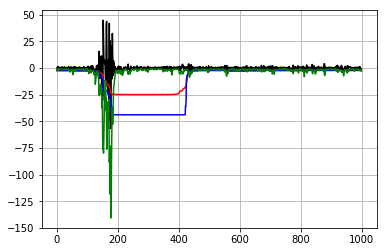

In [ ]:
NOBS = 1000
plt.plot(var_calc[0].vars['Returns'].values[-NOBS:], color = 'black')
plt.plot(var_calc[0].vars['VCA_0.01'].values[-NOBS:], color = 'red')
plt.plot(var_calc[0].vars['HIST_0.01'].values[-NOBS:], color = 'blue')
try:
    plt.plot(data_calc[0].data['True_VAR_0.01'].values[-NOBS:], color = 'green')
except:
    pass
plt.grid()
plt.show()

In [ ]:
import torch
# torch.__version__
from scipy.stats import kurtosis, skew
def create_dataset(dataset, look_back = 250, look_back_s = 15, look_back_l = 100):
    dataX, dataY = [], []
    for i in range(look_back, len(dataset)):
        look_back_data = dataset[i - look_back : i]
        temp = dataset[i - look_back: i]
        data_s = dataset[i - look_back_s: i]
        data_l  = dataset[i - look_back_l: i]   
        a = look_back_data[-10:].tolist()
        a.append(np.mean(data_s))
        a.append(np.mean(data_l))
        a.append(max(data_l))   # Max zysku
        a.append(min(data_l))   # Max straty
        a.append(np.std(data_s))
        a.append(np.std(data_l))
        a.append(skew(data_s))
        a.append(skew(data_l))
        a.append(kurtosis(data_s))
        a.append(kurtosis(data_l))   
        dataX.append(a)
        dataY.append(dataset[i])
    
    return np.array(dataX), np.array(dataY)

In [ ]:
data_X, data_Y = create_dataset(var_calc[0].vars['Returns'].values, look_back = 250, look_back_s = 20, look_back_l = 100)

In [ ]:
train_size = int(len(data_X) * 0.7)
train_X, train_Y = data_X[:train_size], data_Y[:train_size]
test_X, test_Y = data_X[train_size:], data_Y[train_size:]

In [ ]:
def normalize_input(train_X, train_Y, test_X, test_Y, normalization_Params = [], ifInit = True):
    if ifInit:
        muX, sigX  = train_X.mean(0), train_X.std(0)
        muY, sigY  = train_Y.mean(0), train_Y.std(0)
        train_X = (train_X - muX) / sigX
        train_Y = (train_Y - muY) / sigY
        test_X  = (test_X - muX) / sigX
        test_Y  = (test_Y - muY) / sigY
        normalization_Params = {"muX": muX, "sigX": sigX, "muY": muY, "sigY": sigY}
        return(train_X, train_Y, test_X, test_Y, normalization_Params)
    else:
        muX, sigX  = normalization_Params["muX"], normalization_Params["sigX"]
        muY, sigY  = normalization_Params["muY"], normalization_Params["sigY"]
        train_X = (train_X ) * sigX + muX
        train_Y = (train_Y ) * sigY + muY
        test_X  = (test_X ) * sigX + muX
        test_Y  = (test_Y ) * sigY + muY
        return(train_X, train_Y, test_X, test_Y, normalization_Params)
    
train_X = train_X.reshape(train_X.shape[0], 1, len(data_X[0]))
train_Y = train_Y.reshape(train_Y.shape[0], 1, 1)
test_X = test_X.reshape(test_X.shape[0], 1, len(data_X[0]))

train_X = torch.from_numpy(train_X)
train_Y = torch.from_numpy(train_Y)
test_X = torch.from_numpy(test_X)

In [ ]:
train_X, train_Y, test_X, test_Y, normalization_Params = normalize_input(train_X, train_Y, test_X, test_Y)

In [ ]:
from torch import nn
from torch.autograd import Variable
class lstm_reg(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2):
        super(lstm_reg, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, dropout = 0.1)
        self.reg = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x, _ = self.rnn(x)
        s, b, h = x.shape
        x = x.view(s*b, h)
        x = self.reg(x)
        x = x.view(s, b, -1)
        return x

In [ ]:
model = lstm_reg(len(data_X[0]), 10, 1, 2)
model = model.double()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
def quantile_regression(alpha, y, y_hat):
    e = torch.tensor(y - y_hat)
    loss  = torch.cat((alpha*e, (alpha-1)*e))
    loss = loss.reshape(2, int(len(y))).transpose(0, 1)
    loss = loss.max(1)[0]
    loss = loss.mean()
    return(loss)
def quantile_regression_dk(alpha, y, y_hat):
    e = torch.tensor(y - y_hat)
    loss  = torch.cat((alpha*e, (alpha-1)*e))
    loss = loss.reshape(2, int(len(y))).transpose(0, 1)
    loss = loss.max(1)[0][1:]*loss.max(1)[0][:-1]
    loss = loss.mean()
    return(loss)

In [ ]:
def train_2(epoch, alpha, model):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss   = quantile_regression(alpha, target, output)
        loss.backward()
        optimizer.step()
    print('Train Epoch: {} \t Loss: {:.6f}'.format(
        epoch,  loss.data[0]))
    return(model)

Train Epoch: 0 	 Loss: 0.021660
Train Epoch: 1 	 Loss: 0.014358
Train Epoch: 2 	 Loss: 0.013199
Train Epoch: 3 	 Loss: 0.011210
Train Epoch: 4 	 Loss: 0.011511
Train Epoch: 5 	 Loss: 0.010080
Train Epoch: 6 	 Loss: 0.010819
Train Epoch: 7 	 Loss: 0.009539
Train Epoch: 8 	 Loss: 0.009626
Train Epoch: 9 	 Loss: 0.009923
Train Epoch: 10 	 Loss: 0.009117
Train Epoch: 11 	 Loss: 0.008920
Train Epoch: 12 	 Loss: 0.009691
Train Epoch: 13 	 Loss: 0.009609
Train Epoch: 14 	 Loss: 0.008583
Train Epoch: 15 	 Loss: 0.009002
Train Epoch: 16 	 Loss: 0.008467
Train Epoch: 17 	 Loss: 0.008756
Train Epoch: 18 	 Loss: 0.008730
Train Epoch: 19 	 Loss: 0.009483
Train Epoch: 20 	 Loss: 0.008728
Train Epoch: 21 	 Loss: 0.009091
Train Epoch: 22 	 Loss: 0.008257
Train Epoch: 23 	 Loss: 0.009264
Train Epoch: 24 	 Loss: 0.008964
Train Epoch: 25 	 Loss: 0.008941
Train Epoch: 26 	 Loss: 0.009017
Train Epoch: 27 	 Loss: 0.009159
Train Epoch: 28 	 Loss: 0.008467
Train Epoch: 29 	 Loss: 0.009056
Train Epoch: 30 	 Lo

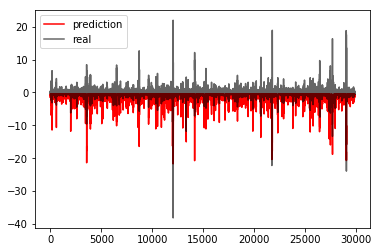

In [ ]:
params = {"period_interval": 250, "alpha": 0.01}
import torch.utils.data as data_utils
import copy
train = data_utils.TensorDataset(torch.tensor(train_X), torch.tensor(train_Y))
train_loader = data_utils.DataLoader(train, batch_size=100, shuffle=False)
xxx = []
yyy = []

#model, l = preOptimizationSearch(model, train_loader, 50, params["alpha"])
number_of_iterations = 50

for epoch in range(number_of_iterations):
    train_2(epoch, params["alpha"], model)
    xxx.append(copy.deepcopy(model.rnn.all_weights))
    yyy.append(copy.deepcopy(model.reg.weight.data))

model = model.eval()
pred_test = model(test_X)
pred_test = pred_test.detach().numpy()
pred_test = pred_test.reshape(len(pred_test))

plt.plot(pred_test, 'red', label='prediction')
plt.plot(test_Y[0].detach().numpy(), 'black', label='real', alpha=0.6)
#plt.plot(true_var, 'green', label='true VaR', alpha=0.6)
plt.legend(loc='best')

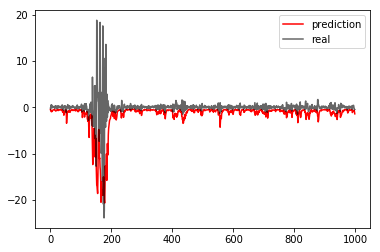

In [ ]:
plt.plot(pred_test[-1000:], 'red', label='prediction')
plt.plot(test_Y[0].detach().numpy()[-1000:], 'black', label='real', alpha=0.6)
#plt.plot(test_Y[0][-700:], 'black', label='real', alpha=0.6)
plt.legend(loc='best')

In [ ]:
print("Is:", np.round(sum(pred_test > test_Y[0].detach().numpy())*1/len(pred_test),4), "Should be: ", params["alpha"])

Is: 0.0077 Should be:  0.01


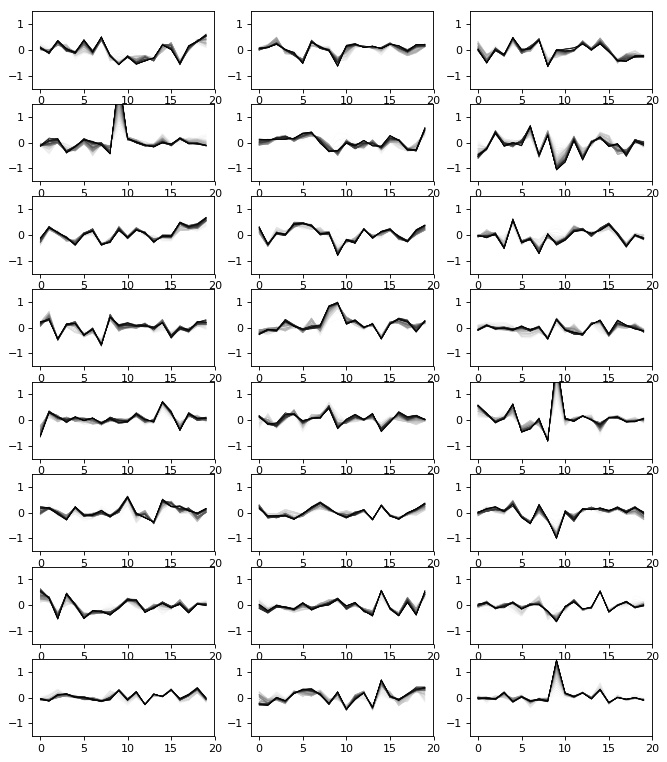

In [ ]:
plt.figure(num=None, figsize=(10, 12), dpi=80, facecolor='w', edgecolor='k')
colors = np.linspace(1, 0, number_of_iterations)
for j  in range(24):
    plt.subplot(8,3, j+1)
    plt.ylim([-1.5, 1.5])
    for i in range(number_of_iterations):    
        plt.plot(xxx[i][0][0][j].detach().numpy(), color = np.str(colors[i]), linewidth = 0.5)

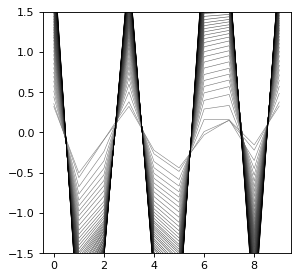

In [ ]:
plt.figure(num=None, figsize=(4, 4), dpi=80, facecolor='w', edgecolor='k')
colors = np.linspace(0.5, 0, number_of_iterations)
for i in range(number_of_iterations):    
    plt.plot(yyy[i].detach().numpy()[0], color = np.str(colors[i]), linewidth = 0.5)
    plt.ylim([-1.5, 1.5])